In [1]:
import math
import numpy as np
import torch
import torch.utils.checkpoint
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.auto import tqdm

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import match_dim_with_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [2]:
batch_size = 512

transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose(transform_list)
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,          
    pin_memory=True,
    persistent_workers=False,
)

batch = next(iter(train_dataloader))
print(batch[0].shape)  # torch.Size([256, 1, 28, 28])

torch.Size([512, 1, 28, 28])


In [3]:
model_type = "unet"
from rectified_flow.models.enhanced_mlp import VarMLP
from rectified_flow.models.utils import EMAModel
from rectified_flow.models.unet import SongUNet, SongUNetConfig

flow_model = SongUNet.from_pretrained("/scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional", use_ema=True).to(device)

Model loaded from /scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional/unet_ema.pt


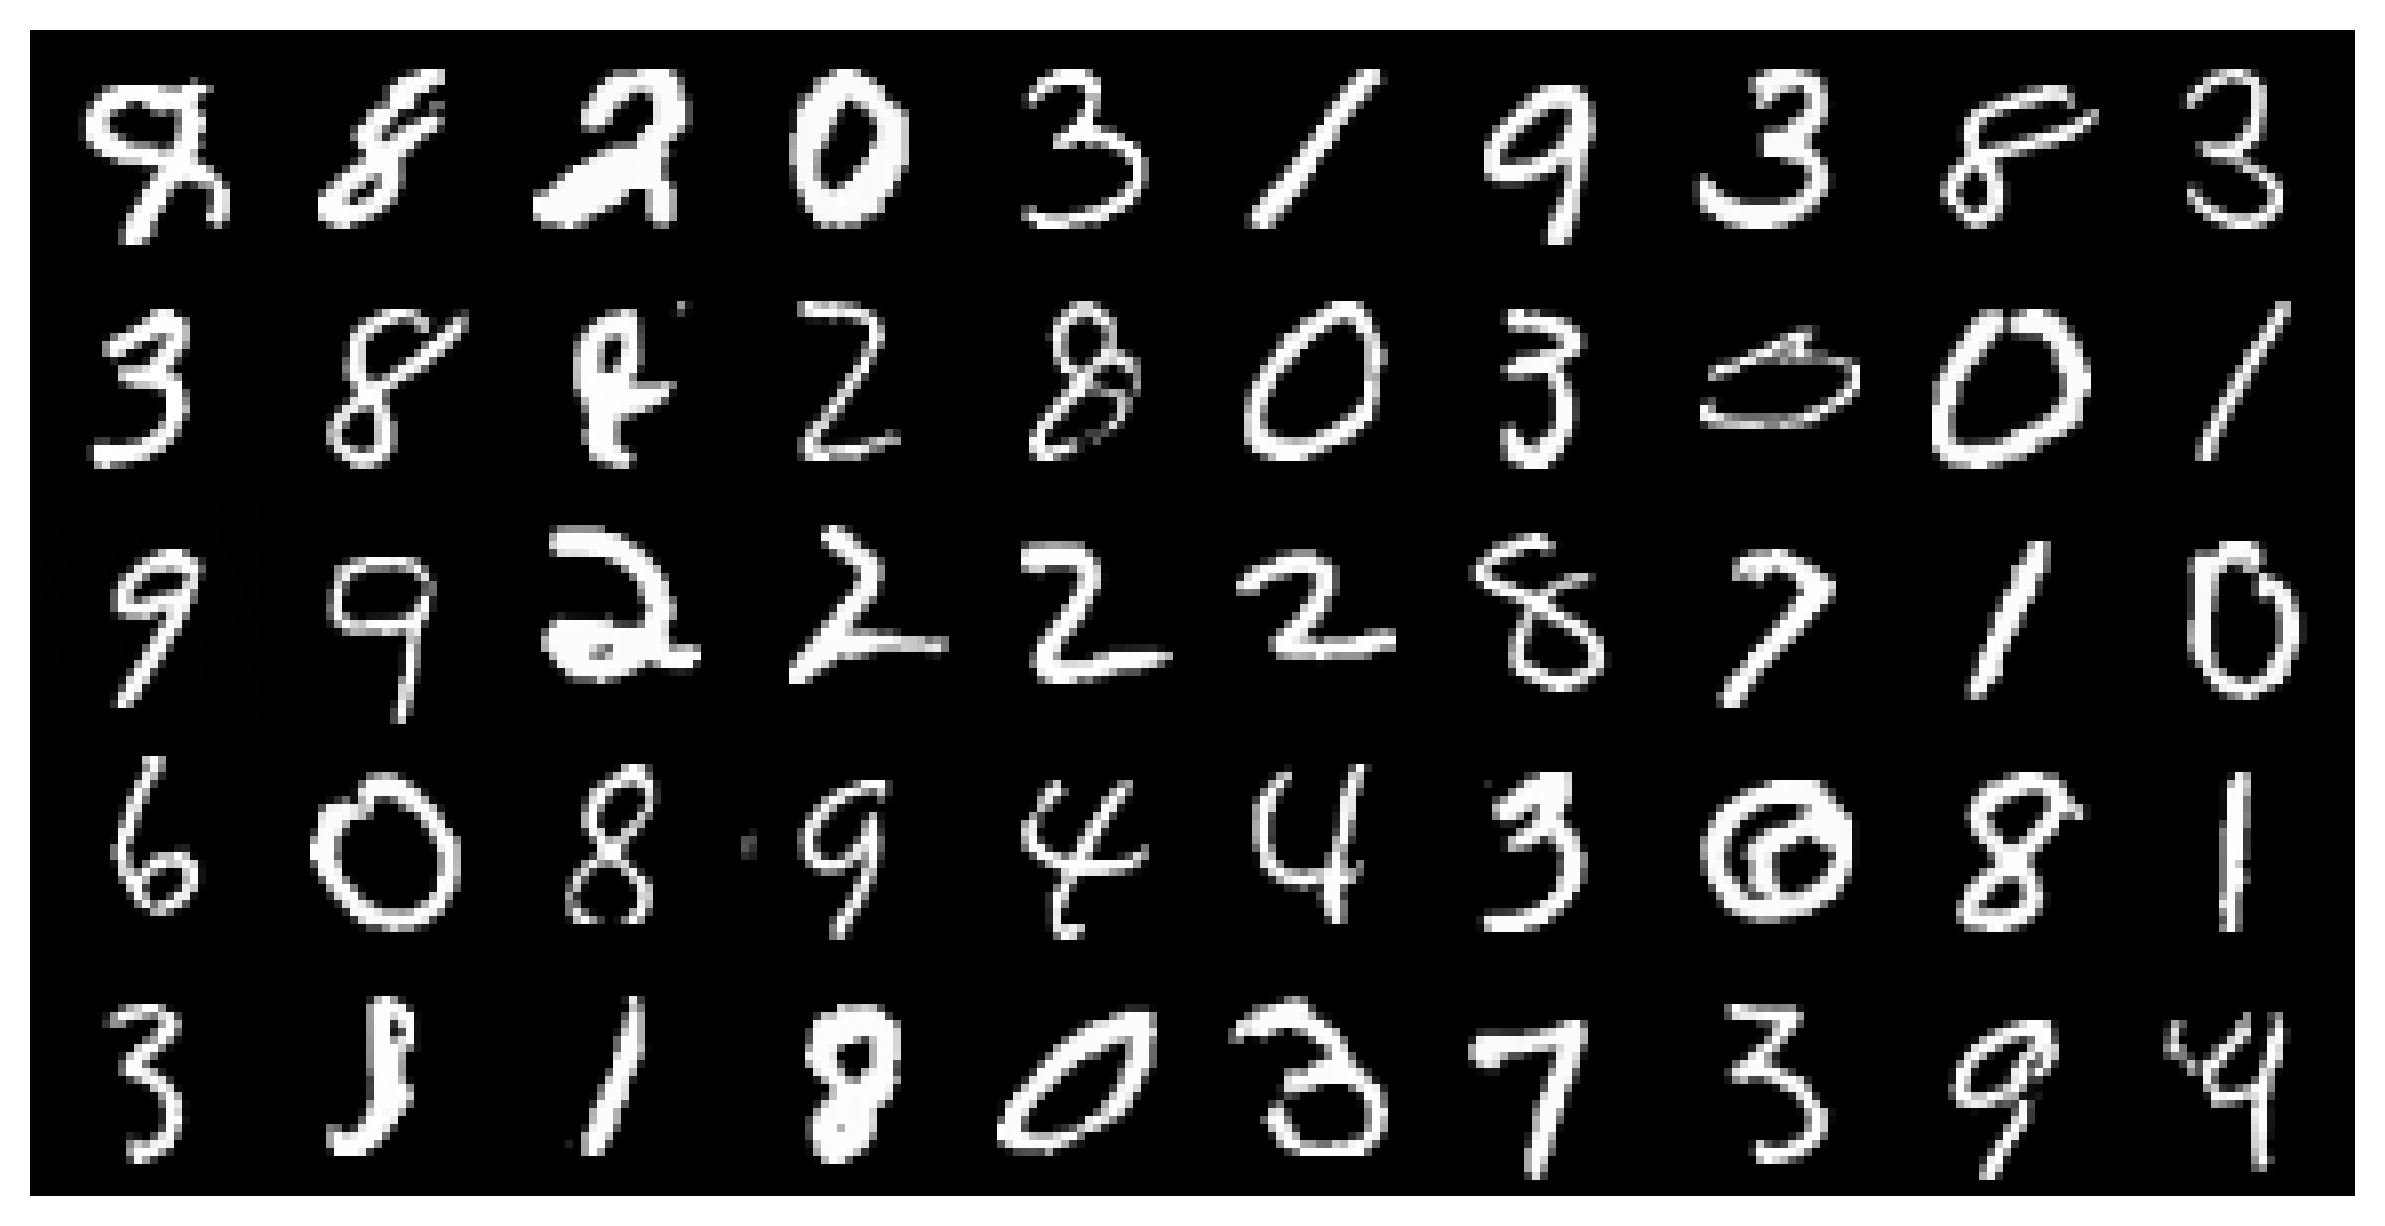

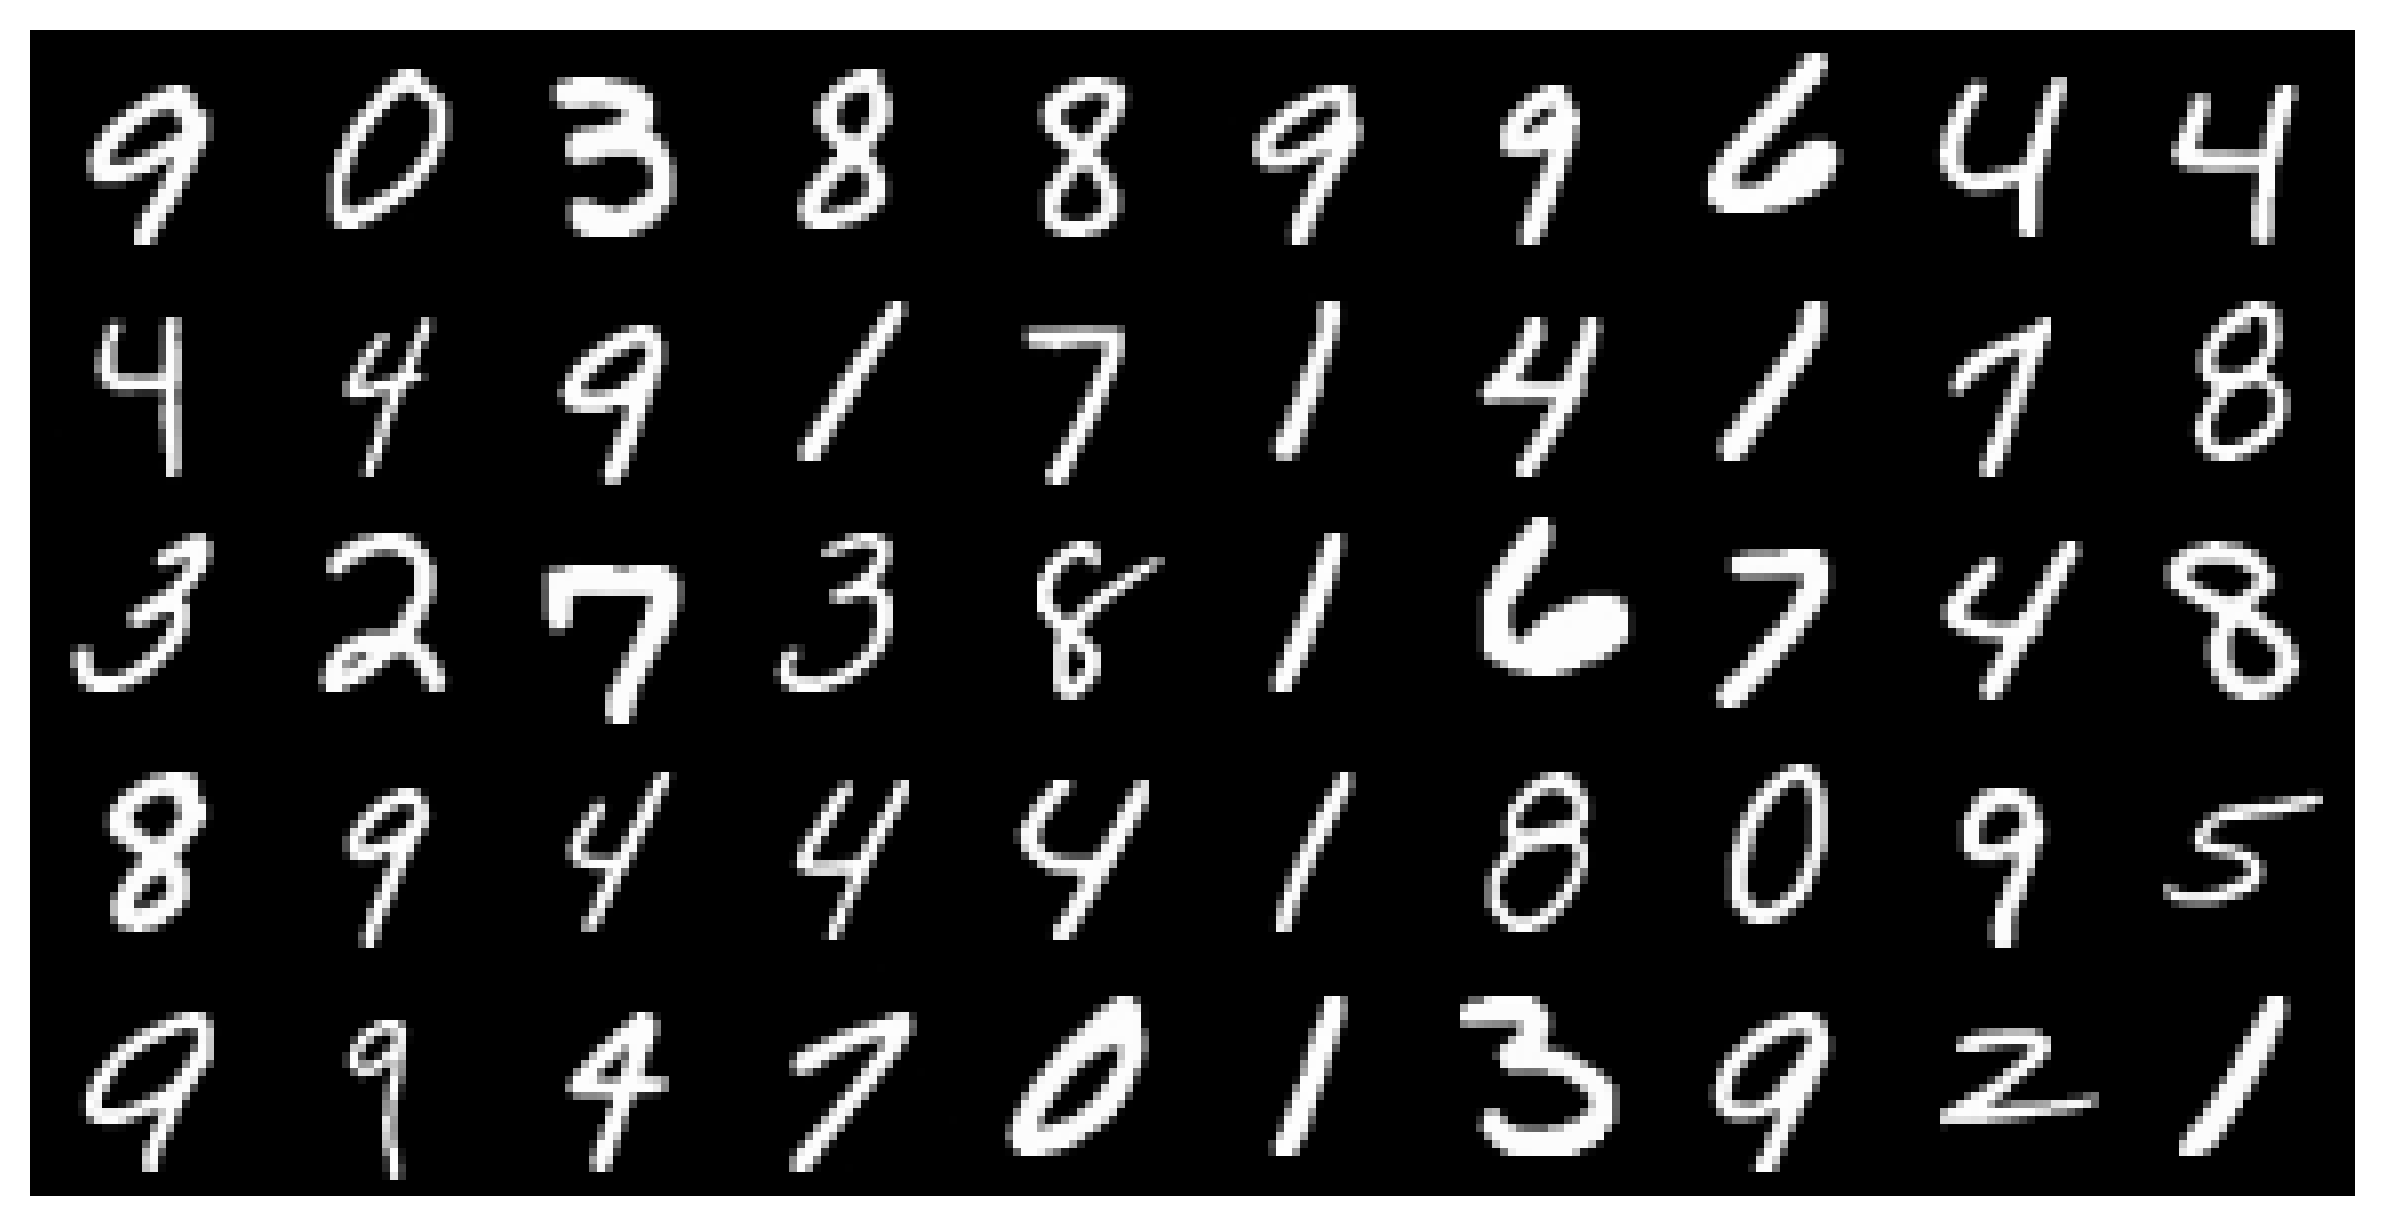

In [4]:
from rectified_flow.samplers import EulerSampler, SDESampler
from rectified_flow.utils import plot_cifar_results

rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)

x_0_src = torch.randn(50, 1, 28, 28, device=device)

sampler = EulerSampler(rectified_flow=rf, num_steps=200)
rf_samples = sampler.sample_loop(x_0=x_0_src).trajectories[-1]

sde_sampler = SDESampler(rectified_flow=rf, num_steps=100, noise_decay_rate=0.0, noise_scale=50.0)
rf_sde_samples = sde_sampler.sample_loop(x_0=x_0_src).trajectories[-1]

plot_cifar_results(rf_samples)
plot_cifar_results(rf_sde_samples)

## Implement divergence estimation and verify correctness

### Exact Jacobian calculation with autograd

In [5]:
from tqdm import tqdm
from torch.autograd.functional import jacobian

def divergence_exact_manual(v_func, x_t, t):
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    div = torch.empty(B, device=device, dtype=dtype)

    for b in tqdm(range(B), desc="Computing exact divergence"):
        xb = x_t[b:b+1].detach().requires_grad_(True)
        tb = t[b:b+1]

        def f(inp):
            return v_func(inp, tb)

        J = jacobian(f, xb, vectorize=False, create_graph=False)
        D = xb.numel()
        div[b] = J.reshape(D, D).diagonal().sum().to(dtype)
        del J
        
    return div

### Divergence Estimation via the Hutchinson Trick

For a vector field $v(x,t)$ with Jacobian $J(x) = \dfrac{\partial v}{\partial x}$, the divergence is
$$
\operatorname{div} v(x,t) = \operatorname{tr}\, J(x).
$$
Computing $\operatorname{tr} J$ via an explicit Jacobian is expensive. The Hutchinson identity gives an unbiased estimator:
$$
\operatorname{tr} J = \mathbb{E}_{\varepsilon}\!\left[\varepsilon^\top J \varepsilon\right],
$$
where $\varepsilon$ can be Rademacher ($\pm1$ w.p. 1/2) or standard Gaussian. A Monte Carlo estimate is
$$
\widehat{\operatorname{div}}(x,t) = \frac{1}{M}\sum_{i=1}^{M} \varepsilon_i^\top (J\,\varepsilon_i),
$$
which only requires Jacobian–vector products (JVP) or vector–Jacobian products (VJP), avoiding materializing the full Jacobian.

**Implementation notes**
- `eps_dist="rademacher"` often yields slightly lower variance; `"normal"` works too.
- Use forward-mode `jvp` to get $J\varepsilon$, or a single backward (VJP) to get $J^\top \varepsilon$ and then dot with $\varepsilon$.
- Compute per-sample inner products in the batch and average across $M$ probes; `M=1–4` is typically sufficient.
- When using fp16/bf16, accumulate in fp32 for numerical stability.


In [6]:
from torch.func import jvp as jvp_func

def divergence_hutchinson(
    v_func,
    x_t: torch.Tensor,
    t: torch.Tensor,
    n_samples: int = 20,
    eps_dist: str = "rademacher",
    method: str = "vjp",
) -> torch.Tensor:
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    D = x_t.numel() // B

    x_flat = x_t.detach().view(B, D)

    acc_dtype = torch.float32 if dtype in (torch.float16, torch.bfloat16) else dtype
    acc = torch.zeros(B, device=device, dtype=acc_dtype)

    def _sample_eps_flat():
        if eps_dist == "rademacher":
            r = torch.randint(0, 2, (B, D), device=device)
            eps = (r * 2 - 1).to(acc_dtype)
        elif eps_dist == "normal":
            eps = torch.randn((B, D), device=device, dtype=acc_dtype)
        else:
            raise ValueError("eps_dist must be 'rademacher' or 'normal'")
        return eps.to(dtype)

    if method == "jvp":
        def f_flat(inp_flat):
            x4 = inp_flat.view(B, *x_t.shape[1:])
            y4 = v_func(x4, t)
            return y4.view(B, D)

        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            _, jvp_out = jvp_func(f_flat, (x_flat,), (eps_flat,), strict=False)  # <-- fix
            acc += (eps_flat * jvp_out).sum(dim=1).to(acc_dtype)

        return (acc / n_samples).to(dtype)

    elif method == "vjp":
        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            eps = eps_flat.view_as(x_t)
            x_req = x_t.detach().requires_grad_(True)
            v = v_func(x_req, t)
            s_per_sample = (v * eps).view(B, -1).sum(dim=1)
            gx = torch.autograd.grad(
                s_per_sample.sum(), x_req, create_graph=False, retain_graph=False
            )[0]
            acc += (gx.detach() * eps).view(B, -1).sum(dim=1).to(acc_dtype)
            del x_req, v, gx, eps, eps_flat, s_per_sample

        return (acc / n_samples).to(dtype)

    else:
        raise ValueError("method must be 'jvp' or 'vjp'")

In [7]:
x_1 = batch[0].to(device)[233:234]
x_1 = x_1.repeat_interleave(6, dim=0)
t = torch.linspace(0.95, 1.0, steps=x_1.shape[0], device=device)
x_t = t[:, None, None, None] * x_1 + (1 - t)[:, None, None, None] * torch.randn_like(x_1)

div_exact = divergence_exact_manual(flow_model, x_t, t)
div_approx = divergence_hutchinson(flow_model, x_t, t, n_samples=20, method="vjp")

print("Divergence shape:", div_exact.shape)
print("div exact:", div_exact)
print("div approx:", div_approx)
print("Max absolute error:", (div_exact - div_approx).abs().max().item())

Computing exact divergence: 100%|██████████| 6/6 [00:31<00:00,  5.25s/it]


Divergence shape: torch.Size([6])
div exact: tensor([-14278.6836, -17663.3906, -23062.6797, -34663.8281, -67080.1016,
        -21070.0566], device='cuda:0')
div approx: tensor([-14273.5615, -17603.3438, -23129.0996, -34726.9375, -67311.7109,
        -20208.3242], device='cuda:0')
Max absolute error: 861.732421875


## log prob estimation with Simultaneous change of variable


$$
\log \rho_t(x^{\mathrm{eval}}) 
= 
\log \rho_0(z_0^{\mathrm{eval}}) 
- 
\int_0^1 \nabla \cdot v_t(z_t^{\mathrm{eval}}) \, \mathrm dt,
$$

where $ \{ z_t^{\mathrm{eval}} \} $ is the solution of 

$$
\dot{z}_t^{\mathrm{eval}} = v_t(z_t^{\mathrm{eval}}), 
\quad \text{with} \quad 
z_1^{\mathrm{eval}} = x^{\mathrm{eval}}.
$$



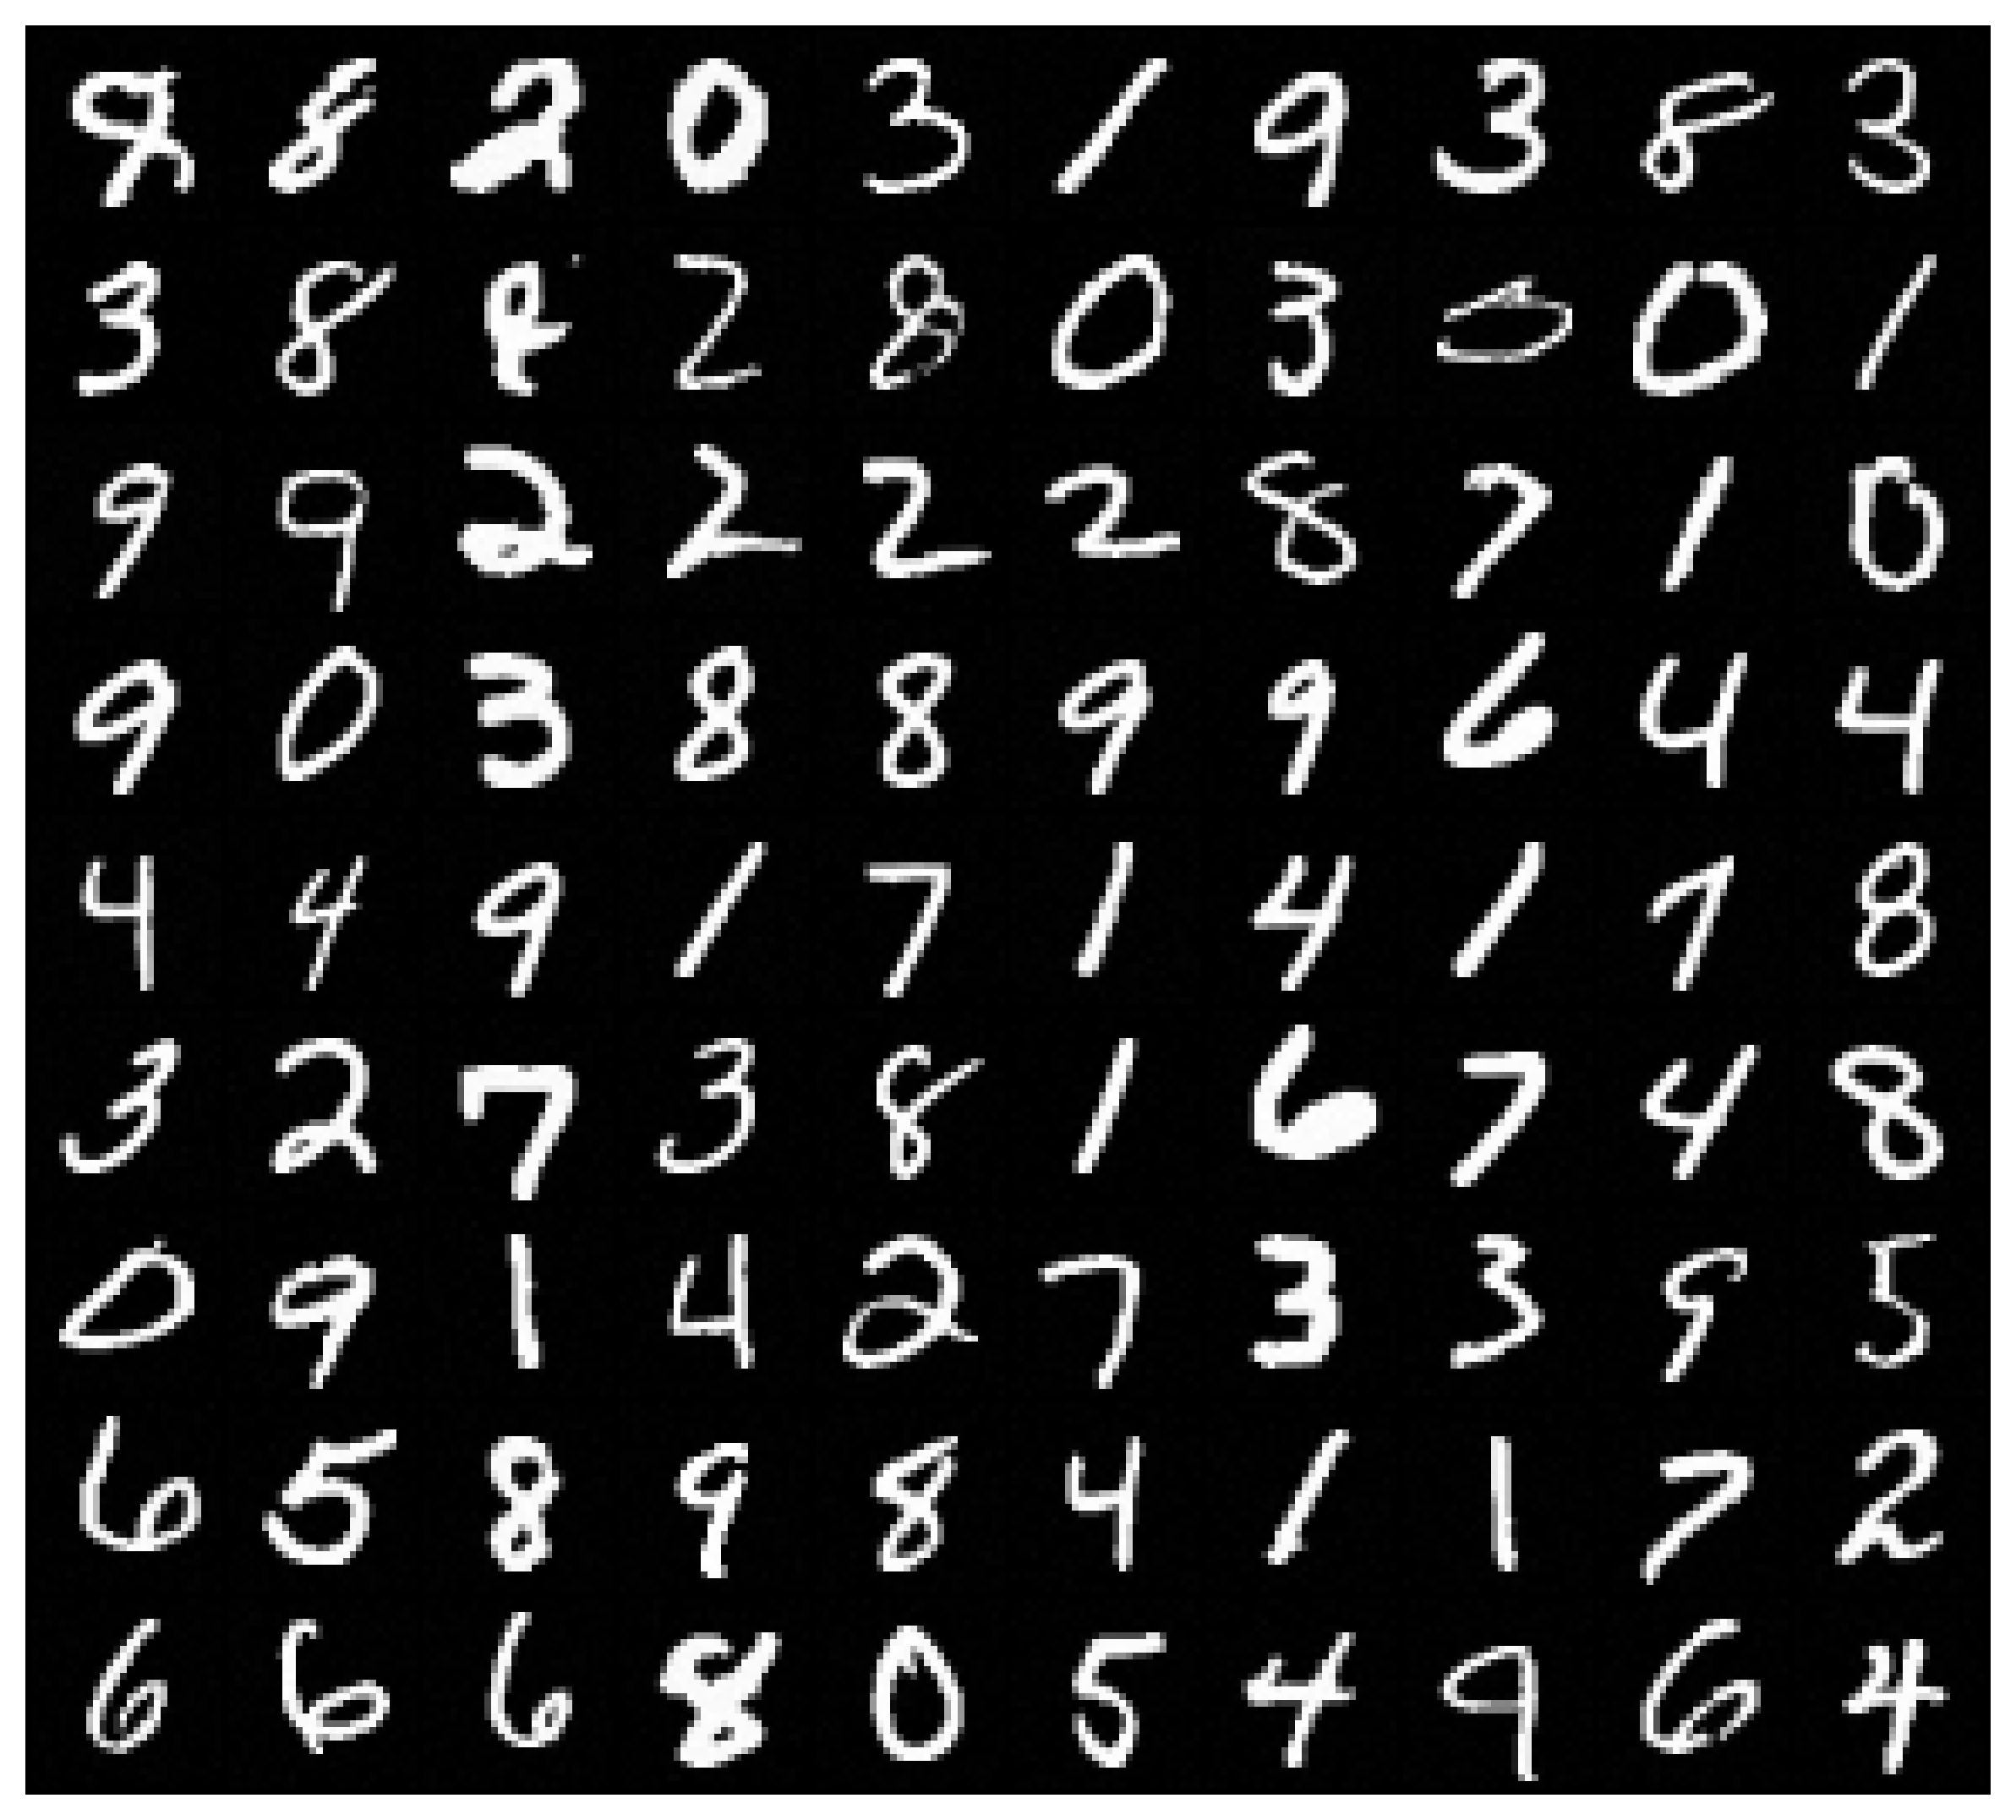

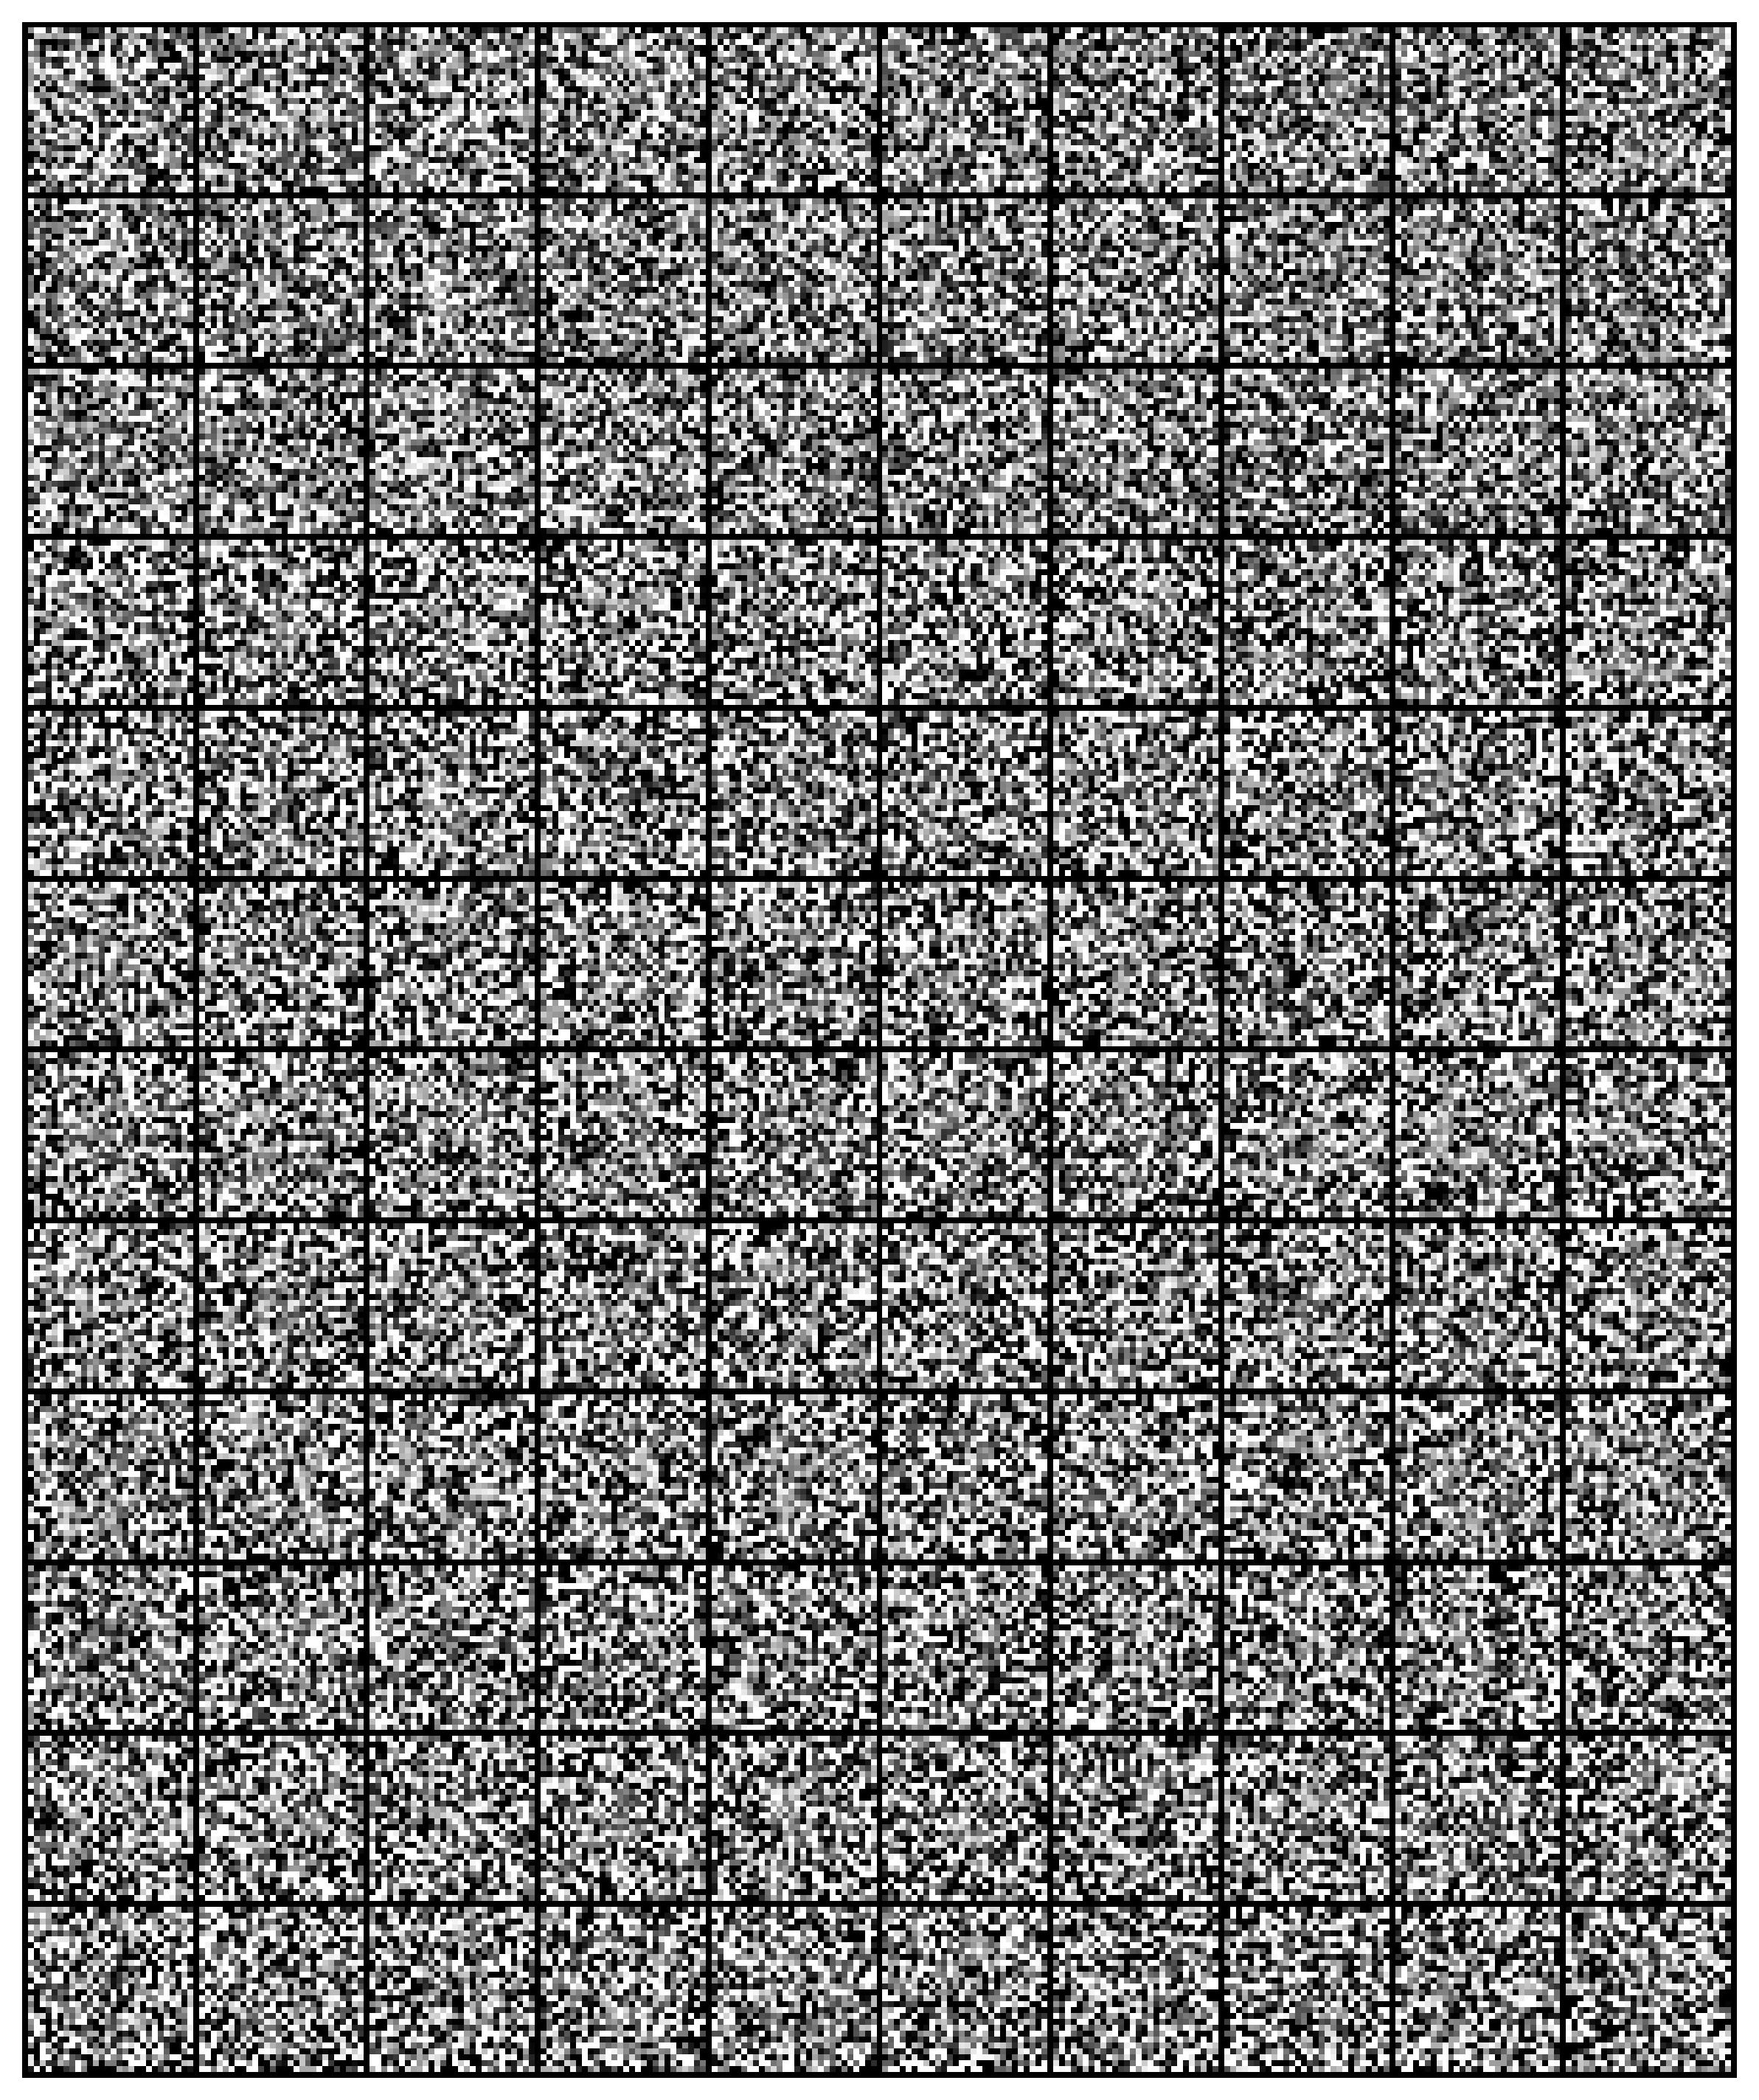

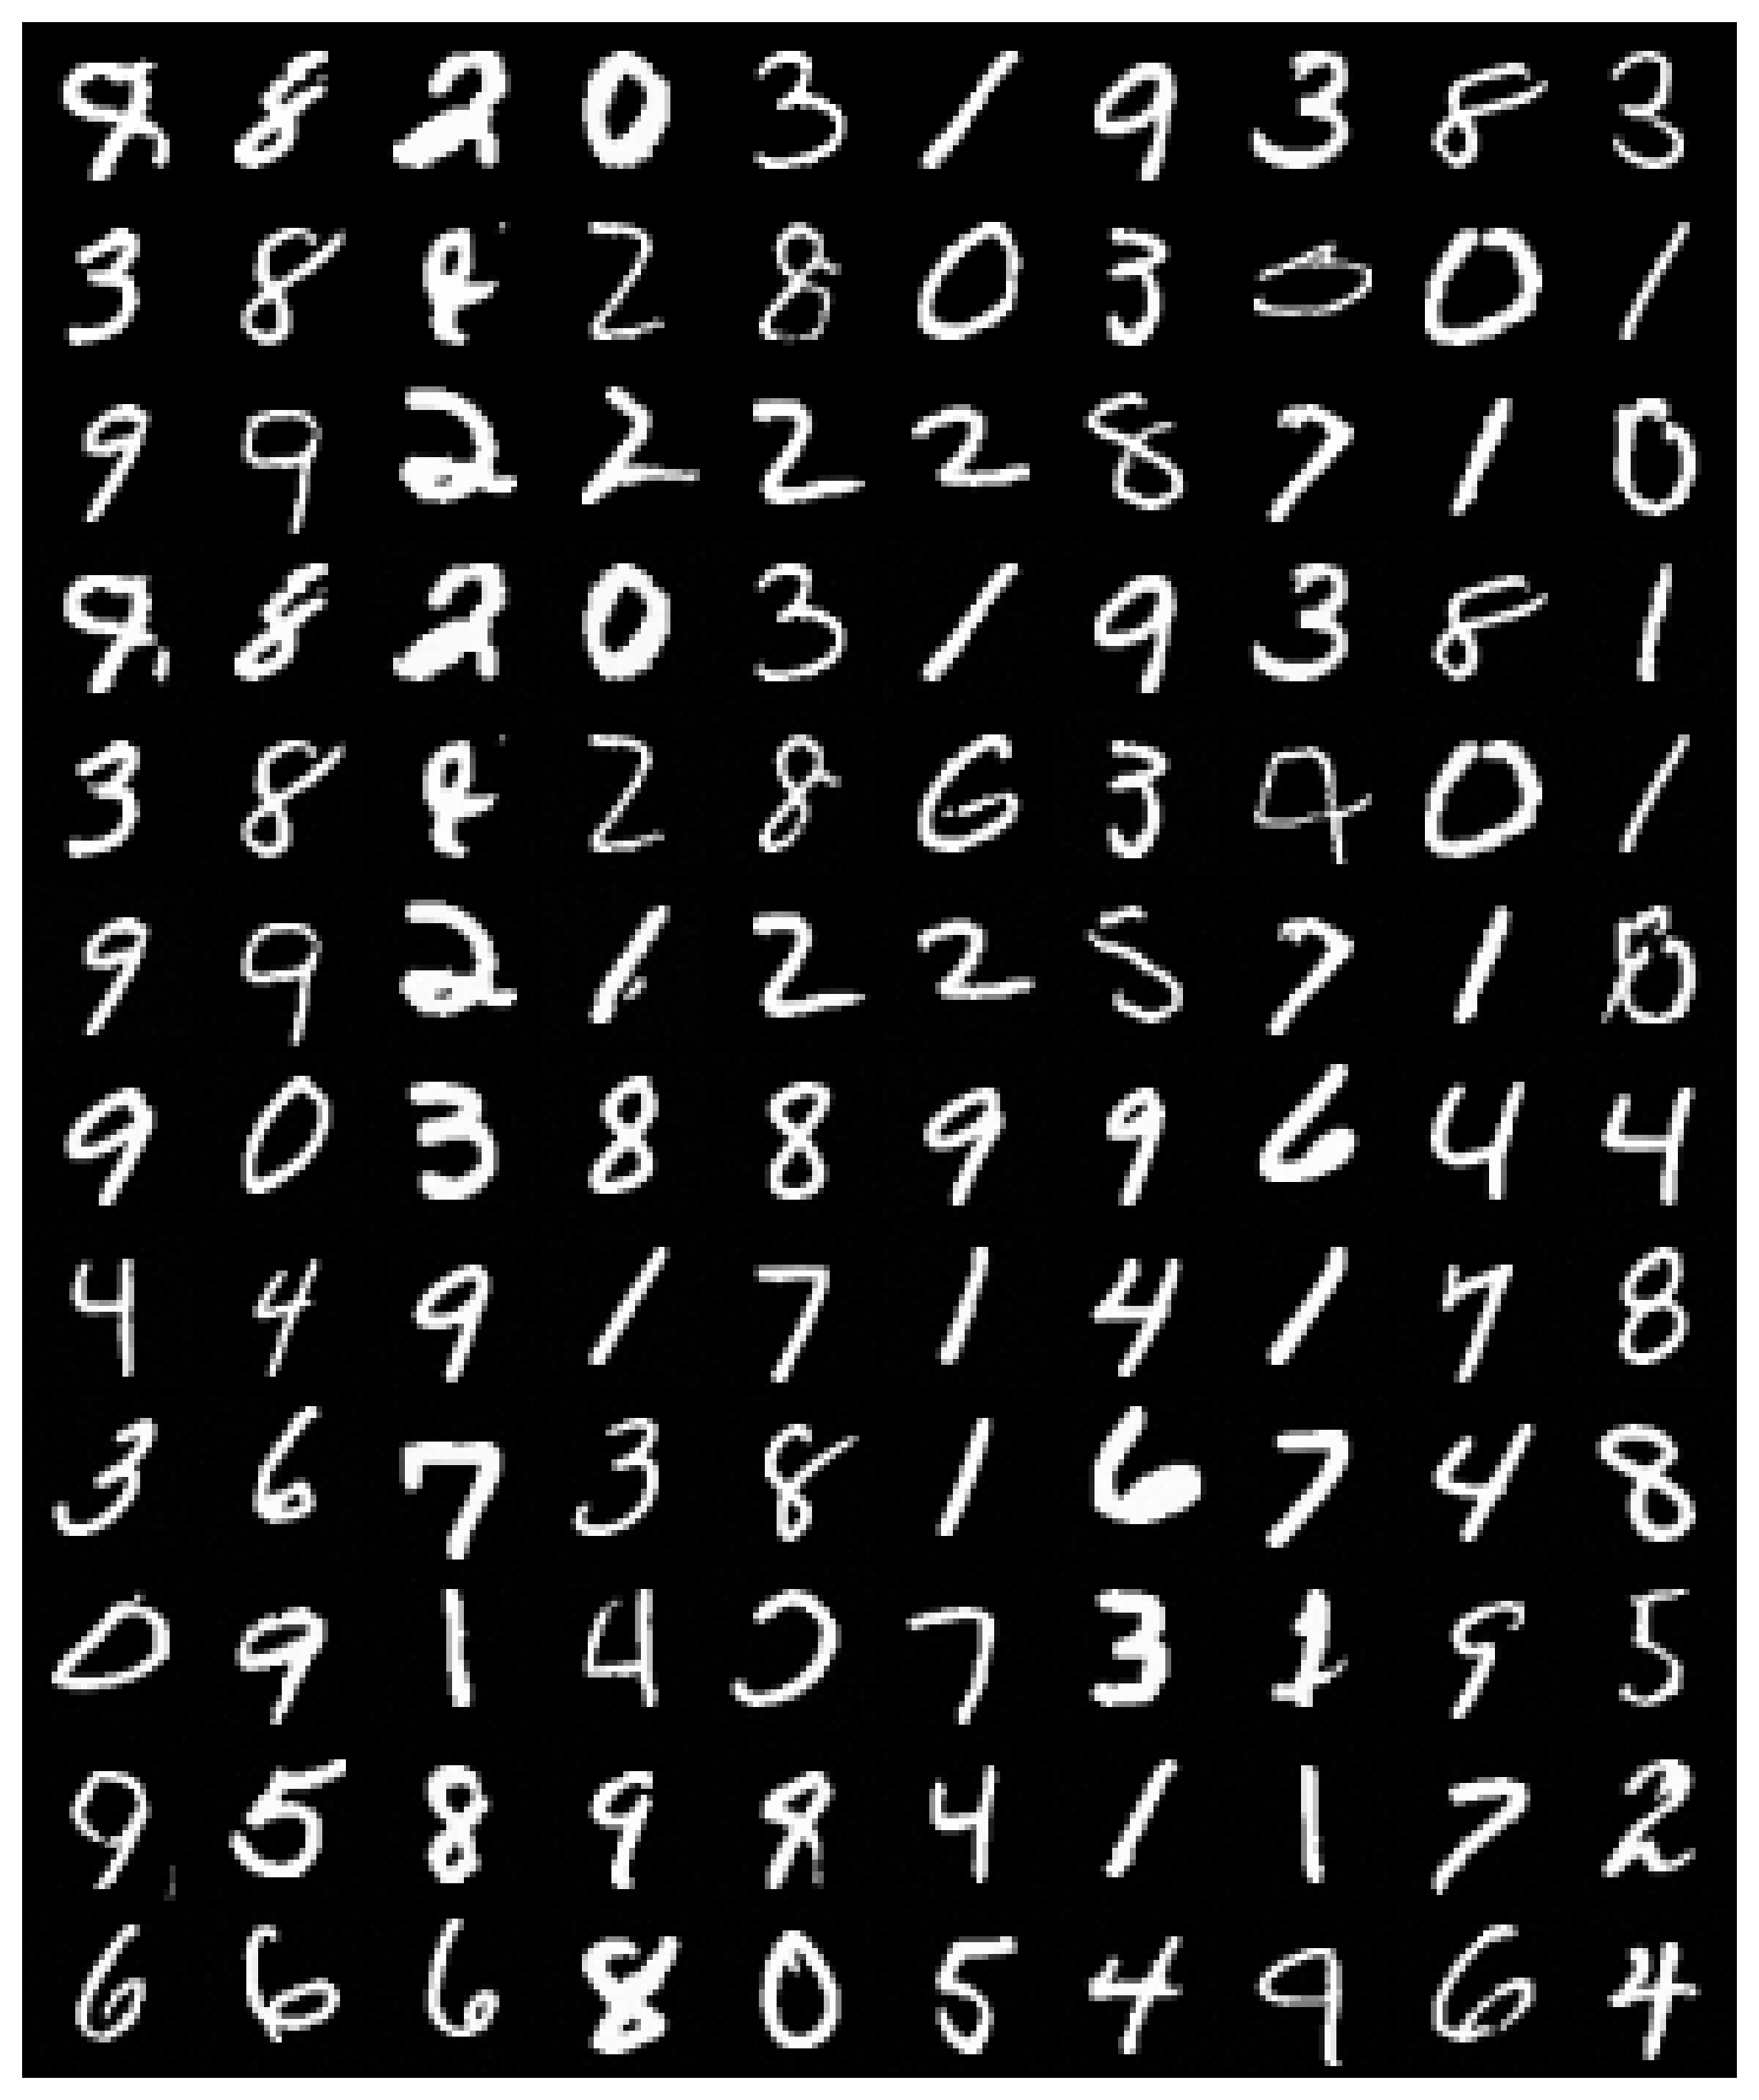

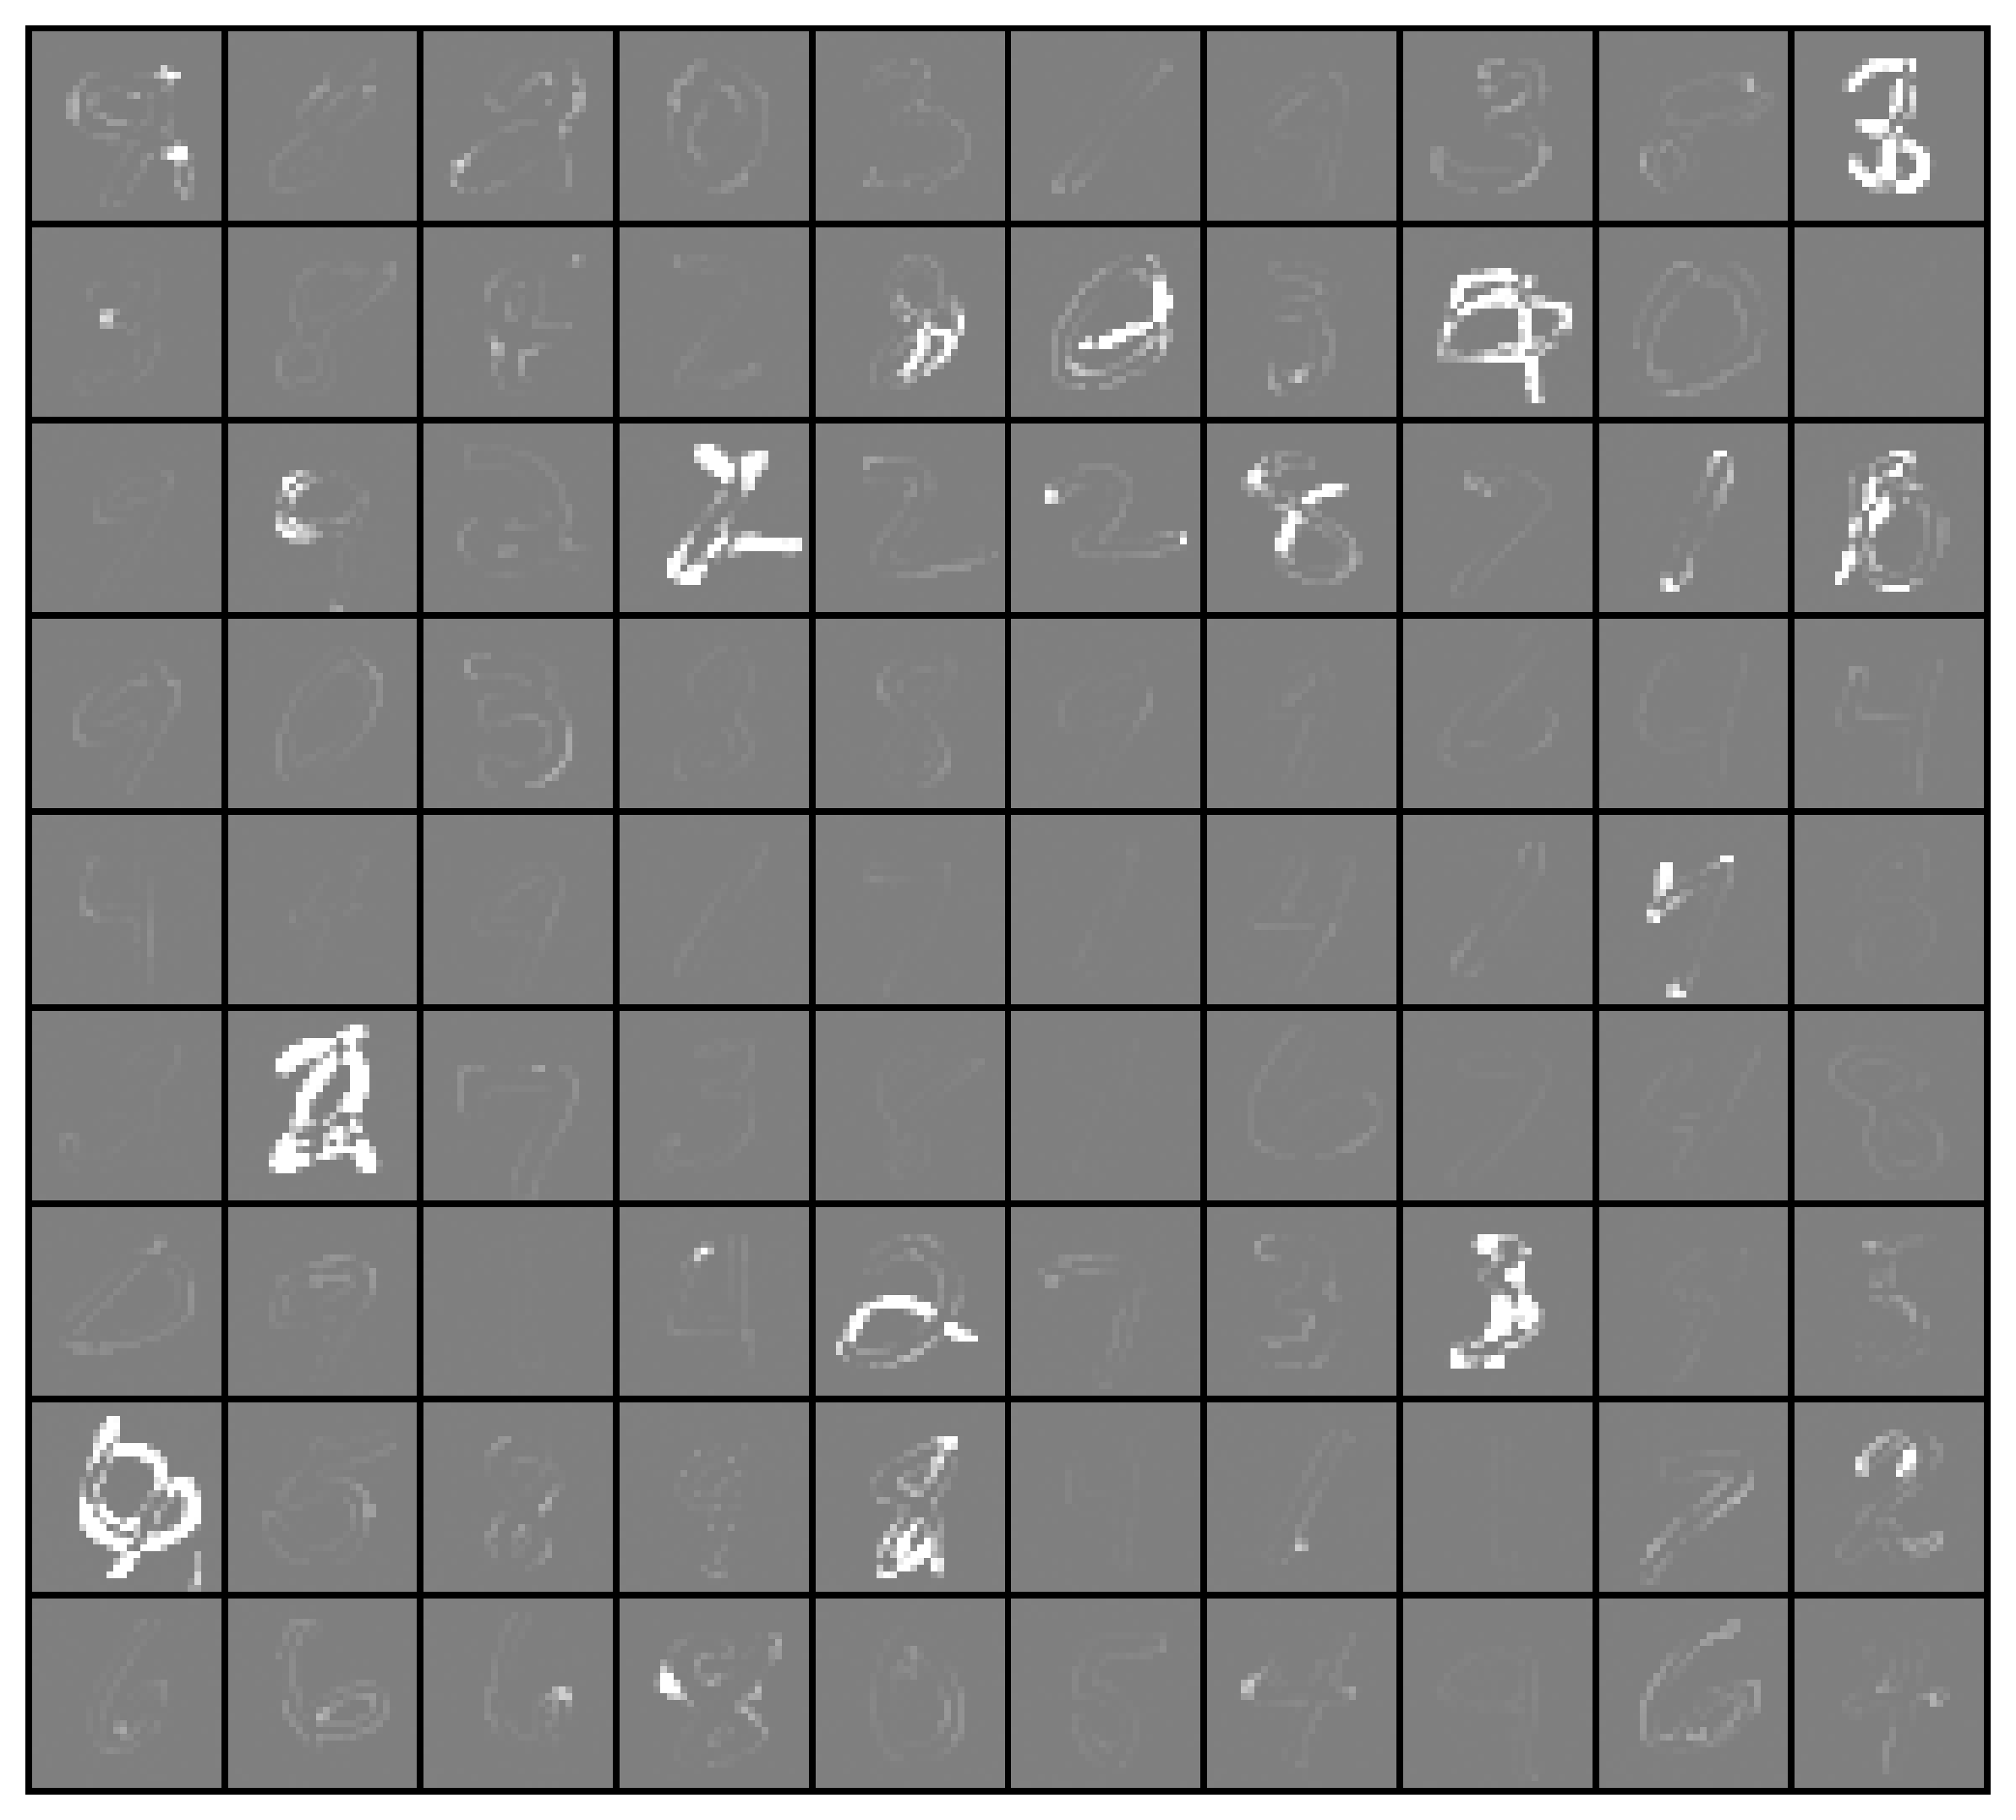

In [8]:
n_samples = 30

x_eval = batch[0].to(device)[:n_samples]
x_eval = torch.cat([
        rf_samples[:n_samples],     # ODE inv
        rf_sde_samples[:n_samples], # SDE inv
        x_eval,              # Test set inv
    ], dim=0)
alpha = 0.01
x_eval = (1. - alpha) * x_eval + alpha * torch.randn_like(x_eval)
# x_eval = x_1
N = 300
plot_cifar_results(x_eval)

# Generate an ODE trajectory for evaluation
time_grid = torch.linspace(0., 1. - alpha, N, device=device)
inv_rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=lambda x, t: -flow_model(x, 1. - t),
    device=device,
)
sampler_inv = EulerSampler(rectified_flow=inv_rf, time_grid=time_grid)
x_0_inv = sampler_inv.sample_loop(x_0=x_eval).trajectories[-1]
x_0_inv = torch.cat((x_0_src[:n_samples], x_0_inv), dim=0) # [ODE vanilla, ODE inv, SDE inv, Test set inv]
plot_cifar_results(x_0_inv)

# Now generate samples from x_0_inv back to x_eval, to see how well we reconstruct
rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)
sampler = EulerSampler(rectified_flow=rf, num_samples=50, num_steps=N)
x_1 = sampler.sample_loop(x_0=x_0_inv).trajectories[-1]
plot_cifar_results(x_1)
plot_cifar_results(torch.abs(x_1[n_samples:] - x_eval))

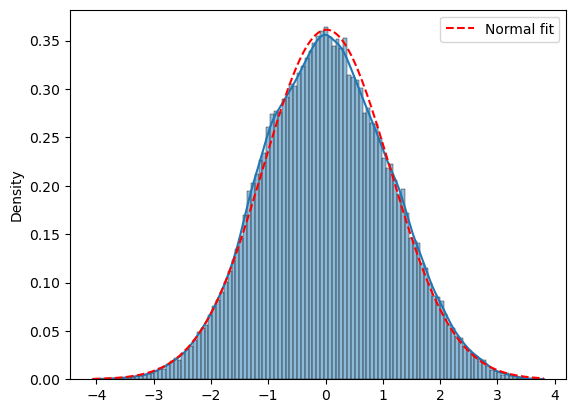

In [9]:
import seaborn as sns
import scipy.stats as stats

x = x_0_inv.view(-1).cpu().numpy()
sns.histplot(x, kde=True, stat="density")
mu, sigma = x.mean(), x.std()
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), 'r--', label='Normal fit')
plt.legend()
plt.show()

In [10]:
def standard_normal_logprob(z):
    B = z.shape[0]
    zf = z.view(B, -1)
    D = zf.shape[1]
    return -0.5 * (zf.pow(2).sum(dim=1) + D * math.log(2 * math.pi))

def estimate_logprob_from_inverse(
    x_0_inv: torch.Tensor,
    rf,                      
    flow_model,
    N: int = 300,
    alpha: float = 0.0,       
    sample_stride: int = 5,
):
    device = x_0_inv.device
    B = x_0_inv.shape[0]

    t1 = max(0.0, 1.0 - alpha)
    time_grid = torch.linspace(0., t1, N, device=device)

    sampler_fwd = EulerSampler(rectified_flow=rf, time_grid=time_grid)
    traj = sampler_fwd.sample_loop(x_0=x_0_inv).trajectories
    states = torch.stack(traj, dim=0) if isinstance(traj, list) else traj     # (T, B, C, H, W)
    T = states.shape[0]

    idx = torch.arange(0, T, sample_stride, device=device)
    if idx[-1].item() != T - 1:
        idx = torch.cat([idx, torch.tensor([T - 1], device=device)])
    t_used = time_grid.index_select(0, idx)               # (Ts,)
    x_used = states.index_select(0, idx)                  # (Ts, B, C, H, W)

    div_values = []
    for k in tqdm(range(t_used.shape[0]), desc="Computing divergences"):
        tk = t_used[k]
        xk = x_used[k]                                     # (B, C, H, W)
        tb = torch.full((B,), tk.item(), device=device)    # (B,)
        div_k = divergence_hutchinson(flow_model, xk, tb, n_samples=30)  # (B,)
        div_values.append(div_k)
        print(f"Time {tk.item():.5f} divergence mean: {div_k.mean().item():.4f}")
    divs = torch.stack(div_values, dim=0)                  # (Ts, B)

    int_div = torch.trapz(divs, t_used, dim=0)            # (B,)
    log_rho0 = standard_normal_logprob(x_0_inv)           # (B,)
    log_rho_eval = log_rho0 - int_div                     # (B,)

    details = {
        "time_grid_full": time_grid,   # (T,)
        "time_grid_used": t_used,      # (Ts,)
        "states_used": x_used,         # (Ts, B, C, H, W)
        "divergences": divs,           # (Ts, B)
        "int_divergence": int_div,     # (B,)
        "log_rho0": log_rho0,          # (B,)
    }
    return log_rho_eval, details

log_rho_eval, details = estimate_logprob_from_inverse(
    x_0_inv=x_0_inv,
    rf=rf,
    flow_model=flow_model,
    N=300,
    alpha=0.0,
    sample_stride=5,
)

Computing divergences:   2%|▏         | 1/61 [00:00<00:39,  1.53it/s]

Time 0.00000 divergence mean: -776.5051


Computing divergences:   3%|▎         | 2/61 [00:01<00:37,  1.58it/s]

Time 0.01672 divergence mean: -783.4507


Computing divergences:   5%|▍         | 3/61 [00:01<00:36,  1.59it/s]

Time 0.03344 divergence mean: -792.0963


Computing divergences:   7%|▋         | 4/61 [00:02<00:35,  1.60it/s]

Time 0.05017 divergence mean: -804.9622


Computing divergences:   8%|▊         | 5/61 [00:03<00:34,  1.61it/s]

Time 0.06689 divergence mean: -814.5455


Computing divergences:  10%|▉         | 6/61 [00:03<00:34,  1.61it/s]

Time 0.08361 divergence mean: -825.6446


Computing divergences:  11%|█▏        | 7/61 [00:04<00:33,  1.61it/s]

Time 0.10033 divergence mean: -835.2490


Computing divergences:  13%|█▎        | 8/61 [00:04<00:32,  1.61it/s]

Time 0.11706 divergence mean: -847.1889


Computing divergences:  15%|█▍        | 9/61 [00:05<00:32,  1.61it/s]

Time 0.13378 divergence mean: -857.3108


Computing divergences:  16%|█▋        | 10/61 [00:06<00:31,  1.61it/s]

Time 0.15050 divergence mean: -872.8637


Computing divergences:  18%|█▊        | 11/61 [00:06<00:30,  1.61it/s]

Time 0.16722 divergence mean: -885.3599


Computing divergences:  20%|█▉        | 12/61 [00:07<00:30,  1.62it/s]

Time 0.18395 divergence mean: -900.5464


Computing divergences:  21%|██▏       | 13/61 [00:08<00:29,  1.62it/s]

Time 0.20067 divergence mean: -918.0305


Computing divergences:  23%|██▎       | 14/61 [00:08<00:29,  1.62it/s]

Time 0.21739 divergence mean: -935.5320


Computing divergences:  25%|██▍       | 15/61 [00:09<00:28,  1.62it/s]

Time 0.23411 divergence mean: -954.9274


Computing divergences:  26%|██▌       | 16/61 [00:09<00:27,  1.62it/s]

Time 0.25084 divergence mean: -979.4581


Computing divergences:  28%|██▊       | 17/61 [00:10<00:27,  1.62it/s]

Time 0.26756 divergence mean: -1001.2598


Computing divergences:  30%|██▉       | 18/61 [00:11<00:26,  1.62it/s]

Time 0.28428 divergence mean: -1022.5105


Computing divergences:  31%|███       | 19/61 [00:11<00:25,  1.62it/s]

Time 0.30100 divergence mean: -1048.2581


Computing divergences:  33%|███▎      | 20/61 [00:12<00:25,  1.62it/s]

Time 0.31773 divergence mean: -1076.0570


Computing divergences:  34%|███▍      | 21/61 [00:13<00:24,  1.62it/s]

Time 0.33445 divergence mean: -1105.0260


Computing divergences:  36%|███▌      | 22/61 [00:13<00:24,  1.62it/s]

Time 0.35117 divergence mean: -1136.2200


Computing divergences:  38%|███▊      | 23/61 [00:14<00:23,  1.62it/s]

Time 0.36789 divergence mean: -1167.7194


Computing divergences:  39%|███▉      | 24/61 [00:14<00:22,  1.62it/s]

Time 0.38462 divergence mean: -1201.4269


Computing divergences:  41%|████      | 25/61 [00:15<00:22,  1.62it/s]

Time 0.40134 divergence mean: -1232.9468


Computing divergences:  43%|████▎     | 26/61 [00:16<00:21,  1.62it/s]

Time 0.41806 divergence mean: -1263.3636


Computing divergences:  44%|████▍     | 27/61 [00:16<00:21,  1.62it/s]

Time 0.43478 divergence mean: -1301.6346


Computing divergences:  46%|████▌     | 28/61 [00:17<00:20,  1.62it/s]

Time 0.45151 divergence mean: -1341.0754


Computing divergences:  48%|████▊     | 29/61 [00:17<00:19,  1.62it/s]

Time 0.46823 divergence mean: -1383.5045


Computing divergences:  49%|████▉     | 30/61 [00:18<00:19,  1.62it/s]

Time 0.48495 divergence mean: -1437.5306


Computing divergences:  51%|█████     | 31/61 [00:19<00:18,  1.62it/s]

Time 0.50167 divergence mean: -1480.7150


Computing divergences:  52%|█████▏    | 32/61 [00:19<00:17,  1.61it/s]

Time 0.51839 divergence mean: -1529.0641


Computing divergences:  54%|█████▍    | 33/61 [00:20<00:17,  1.62it/s]

Time 0.53512 divergence mean: -1573.6399


Computing divergences:  56%|█████▌    | 34/61 [00:21<00:16,  1.62it/s]

Time 0.55184 divergence mean: -1636.4868


Computing divergences:  57%|█████▋    | 35/61 [00:21<00:16,  1.62it/s]

Time 0.56856 divergence mean: -1700.4177


Computing divergences:  59%|█████▉    | 36/61 [00:22<00:15,  1.62it/s]

Time 0.58528 divergence mean: -1773.5217


Computing divergences:  61%|██████    | 37/61 [00:22<00:14,  1.62it/s]

Time 0.60201 divergence mean: -1834.8090


Computing divergences:  62%|██████▏   | 38/61 [00:23<00:14,  1.62it/s]

Time 0.61873 divergence mean: -1916.2180


Computing divergences:  64%|██████▍   | 39/61 [00:24<00:13,  1.62it/s]

Time 0.63545 divergence mean: -1994.0868


Computing divergences:  66%|██████▌   | 40/61 [00:24<00:12,  1.62it/s]

Time 0.65217 divergence mean: -2089.0845


Computing divergences:  67%|██████▋   | 41/61 [00:25<00:12,  1.62it/s]

Time 0.66890 divergence mean: -2187.3152


Computing divergences:  69%|██████▉   | 42/61 [00:26<00:11,  1.62it/s]

Time 0.68562 divergence mean: -2303.3374


Computing divergences:  70%|███████   | 43/61 [00:26<00:11,  1.62it/s]

Time 0.70234 divergence mean: -2422.5127


Computing divergences:  72%|███████▏  | 44/61 [00:27<00:10,  1.62it/s]

Time 0.71906 divergence mean: -2556.3638


Computing divergences:  74%|███████▍  | 45/61 [00:27<00:09,  1.62it/s]

Time 0.73579 divergence mean: -2708.7839


Computing divergences:  75%|███████▌  | 46/61 [00:28<00:09,  1.62it/s]

Time 0.75251 divergence mean: -2882.1245


Computing divergences:  77%|███████▋  | 47/61 [00:29<00:08,  1.62it/s]

Time 0.76923 divergence mean: -3073.0688


Computing divergences:  79%|███████▊  | 48/61 [00:29<00:08,  1.62it/s]

Time 0.78595 divergence mean: -3306.5444


Computing divergences:  80%|████████  | 49/61 [00:30<00:07,  1.62it/s]

Time 0.80268 divergence mean: -3576.5195


Computing divergences:  82%|████████▏ | 50/61 [00:30<00:06,  1.62it/s]

Time 0.81940 divergence mean: -3877.7576


Computing divergences:  84%|████████▎ | 51/61 [00:31<00:06,  1.62it/s]

Time 0.83612 divergence mean: -4248.4829


Computing divergences:  85%|████████▌ | 52/61 [00:32<00:05,  1.62it/s]

Time 0.85284 divergence mean: -4675.2021


Computing divergences:  87%|████████▋ | 53/61 [00:32<00:04,  1.62it/s]

Time 0.86957 divergence mean: -5229.4116


Computing divergences:  89%|████████▊ | 54/61 [00:33<00:04,  1.62it/s]

Time 0.88629 divergence mean: -5925.5762


Computing divergences:  90%|█████████ | 55/61 [00:34<00:03,  1.62it/s]

Time 0.90301 divergence mean: -6871.6587


Computing divergences:  92%|█████████▏| 56/61 [00:34<00:03,  1.62it/s]

Time 0.91973 divergence mean: -8149.7466


Computing divergences:  93%|█████████▎| 57/61 [00:35<00:02,  1.62it/s]

Time 0.93645 divergence mean: -10057.5303


Computing divergences:  95%|█████████▌| 58/61 [00:35<00:01,  1.62it/s]

Time 0.95318 divergence mean: -13166.4824


Computing divergences:  97%|█████████▋| 59/61 [00:36<00:01,  1.62it/s]

Time 0.96990 divergence mean: -19399.4668


Computing divergences:  98%|█████████▊| 60/61 [00:37<00:00,  1.62it/s]

Time 0.98662 divergence mean: -37938.3633


Computing divergences: 100%|██████████| 61/61 [00:37<00:00,  1.61it/s]

Time 1.00000 divergence mean: -50350.9609


In [15]:
# [ODE vanilla, ODE inv, SDE inv, Test set inv]

print("ODE_vanilla logp mean",log_rho_eval[:n_samples].mean())

print("ODE_inv logp mean",log_rho_eval[n_samples:2*n_samples].mean())

print("SDE_inv logp mean",log_rho_eval[2*n_samples:3*n_samples].mean())

print("Test_set logp mean",log_rho_eval[3*n_samples:4*n_samples].mean())

ODE_vanilla logp mean tensor(2534.9824, device='cuda:0')
ODE_inv logp mean tensor(2163.0054, device='cuda:0')
SDE_inv logp mean tensor(2256.5981, device='cuda:0')
Test_set logp mean tensor(2200.1560, device='cuda:0')


In [12]:
def bpd_from_logrho(log_rho, D, b=8, a=1.0):
    # logrho: per-sample log ρ1(x) in nats (model coordinate)
    # D: H*W*C,  a: per-dim linear scale from y∈[0,1] to x (e.g., a=2 for [-1,1])
    import math
    return -log_rho / (D * math.log(2.0)) + b - math.log2(a)

bpd_eval = bpd_from_logrho(log_rho_eval, D=28*28*1, b=8, a=1.0)
print("BPD Eval mean:", bpd_eval.mean().item())

BPD Eval mean: 3.7884249687194824


In [13]:
details["log_rho0"]

tensor([-1139.6650, -1114.1394, -1103.5417, -1119.2460, -1136.1106, -1073.2635,
        -1128.3794, -1082.4762, -1102.2900, -1072.8633, -1119.3855, -1113.2446,
        -1102.8286, -1129.8740, -1090.0833, -1116.5432, -1131.5465, -1083.3684,
        -1108.3330, -1123.7317, -1086.6663, -1124.3896, -1122.2628, -1132.2419,
        -1110.2319, -1132.9213, -1114.8118, -1127.2610, -1105.4583, -1095.0088,
        -1249.9291, -1240.0834, -1248.8181, -1235.4692, -1238.0945, -1228.7065,
        -1227.0311, -1228.2385, -1231.9569, -1229.5559, -1238.2266, -1229.3442,
        -1227.7671, -1242.7300, -1222.7949, -1236.3193, -1235.9802, -1228.2633,
        -1237.2937, -1220.7169, -1218.3322, -1225.3070, -1229.8535, -1215.3674,
        -1222.6345, -1223.4587, -1236.5310, -1242.6969, -1213.6763, -1235.5762,
        -1213.8701, -1212.3813, -1206.3235, -1217.3235, -1218.1709, -1220.7278,
        -1215.3705, -1213.3752, -1227.0286, -1224.4440, -1222.1345, -1225.0696,
        -1225.9572, -1206.0637, -1223.07

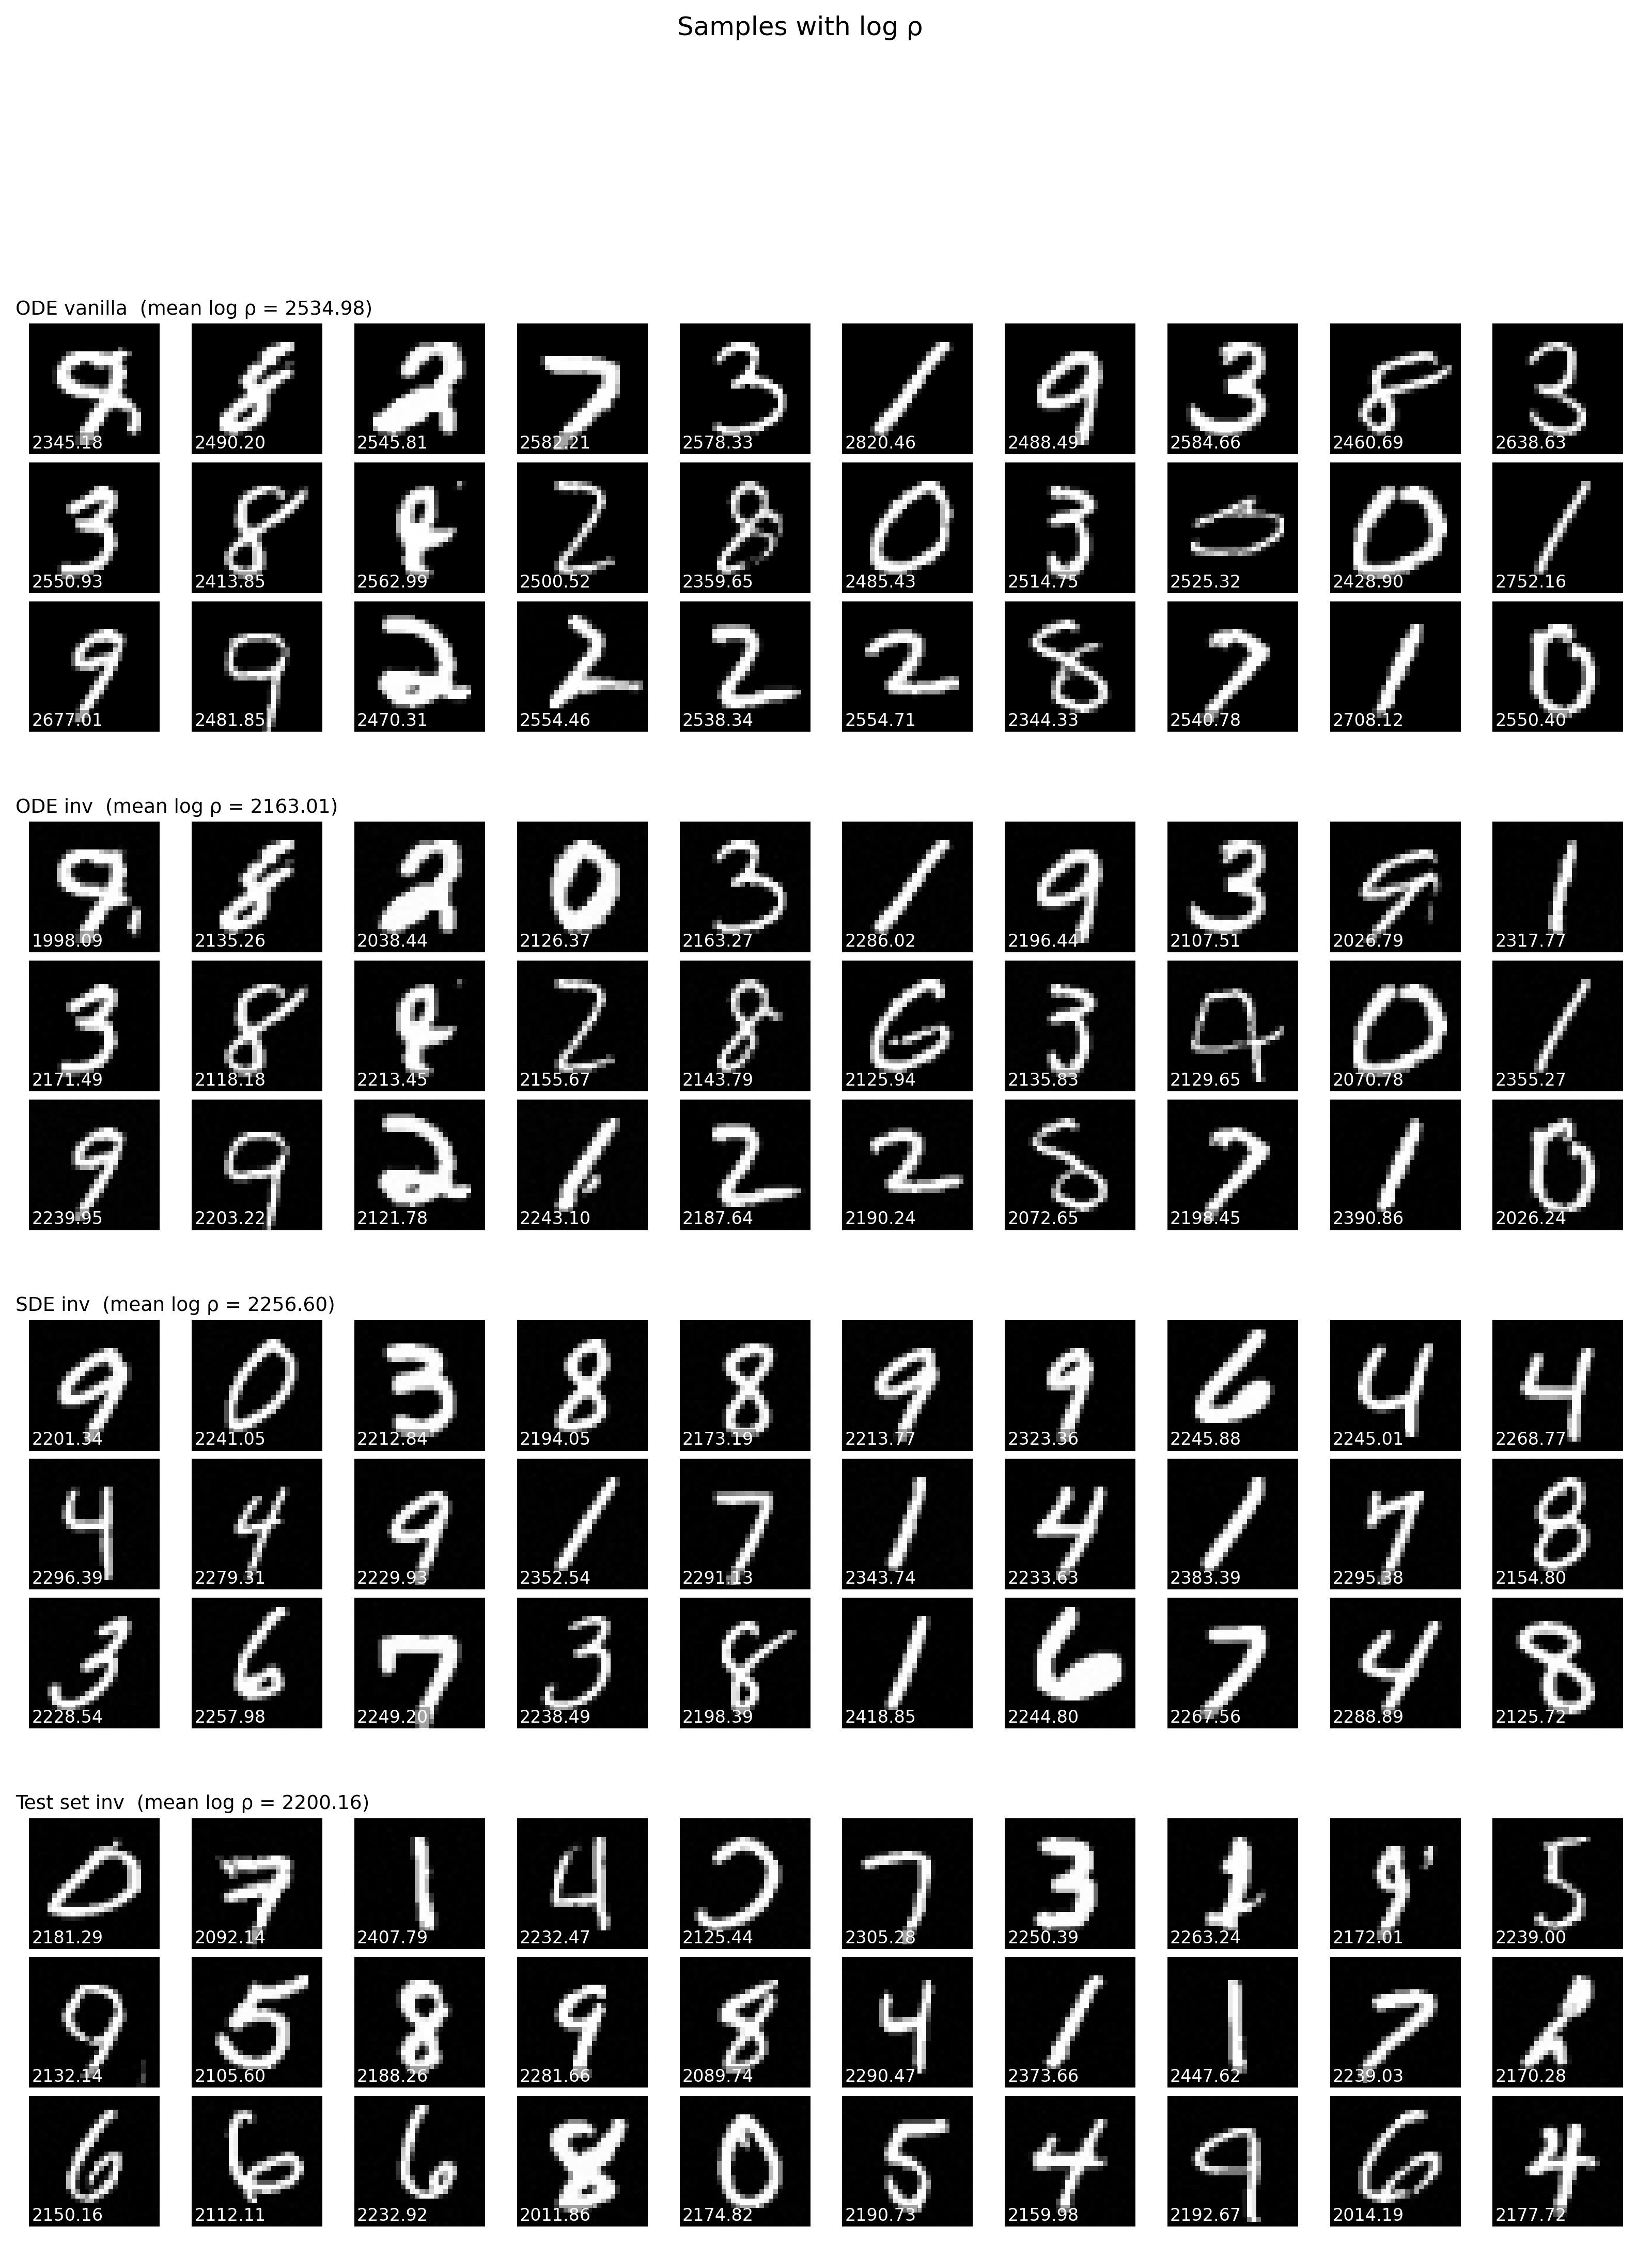

In [21]:
@torch.no_grad()
def plot_images_with_logrho(
    images: torch.Tensor,
    log_rho: torch.Tensor,
    nrow: int = 10,
    title: str | None = None,
    digits: int = 2,
    dpi: int = 300,
    fontsize: int = 8,
    normalize_from_neg1_pos1: bool = True,
    save_path: str | None = None,
    group_titles: list[str] | None = None,
    group_size: int | None = None,
    show_group_mean: bool = False,
):
    import math
    import torch
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    assert images.ndim == 4, "images should be (B, C, H, W)"
    B = images.shape[0]
    cols = min(nrow, B)

    imgs = images.detach().cpu().clone()
    if normalize_from_neg1_pos1:
        imgs = (imgs * 0.5 + 0.5).clamp(0, 1)

    scores = log_rho.detach().cpu().view(-1)
    assert scores.numel() == B, "log_rho length must match number of images"

    # 分段
    groups = []
    if group_titles is not None and group_size is not None:
        total_needed = group_size * len(group_titles)
        assert total_needed <= B, "group_size * len(group_titles) exceeds number of images"
        start = 0
        for name in group_titles:
            end = start + group_size
            groups.append((name, start, end))
            start = end
    else:
        groups.append(("All", 0, B))

    rows_per_group = [math.ceil((e - s) / cols) for _, s, e in groups]

    col_width  = 1.35
    row_height = 1.30
    title_frac = 0.10     
    group_hspace = 0.16   
    cell_hspace  = 0.08   
    cell_wspace  = 0.03   

    fig_w = cols * col_width
    fig_h = sum(r * row_height + title_frac * row_height for r in rows_per_group)

    fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
    outer = gridspec.GridSpec(
        nrows=len(groups), ncols=1,
        height_ratios=[(title_frac + r) for r in rows_per_group],
        hspace=group_hspace,
    )

    for gi, (gname, s, e) in enumerate(groups):
        r = rows_per_group[gi]
        sub = outer[gi].subgridspec(
            r + 1, cols,
            height_ratios=[title_frac] + [1]*r,
            wspace=cell_wspace, hspace=cell_hspace
        )

        ax_title = fig.add_subplot(sub[0, :])
        ax_title.axis("off")
        if show_group_mean:
            mean_val = scores[s:e].mean().item()
            txt = f"{gname}  (mean log ρ = {mean_val:.{digits}f})"
        else:
            txt = gname
        ax_title.text(0.0, 0.5, txt, fontsize=fontsize+1, va="center", ha="left")

        for k in range(r * cols):
            ax = fig.add_subplot(sub[1 + k // cols, k % cols])
            idx = s + k
            if idx < e:
                img = imgs[idx]
                if img.shape[0] == 1:
                    ax.imshow(img.squeeze(0), cmap="gray")
                else:
                    ax.imshow(img.permute(1, 2, 0).numpy())
                ax.set_xticks([]); ax.set_yticks([])
                for sp in ax.spines.values():
                    sp.set_visible(False)

                # 把分数放到图内左下角，避免 xlabel 留白
                label = f"{scores[idx].item():.{digits}f}"
                ax.text(
                    0.02, 0.02, label,
                    transform=ax.transAxes, ha="left", va="bottom",
                    fontsize=fontsize, color="white",
                    bbox=dict(facecolor="black", alpha=0.35, pad=1.0, edgecolor="none"),
                )
            else:
                ax.axis("off")

    if title is not None:
        fig.suptitle(title, fontsize=12, y=0.995)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05)
    plt.show()


plot_images_with_logrho(
    images=details["states_used"][-1],
    log_rho=log_rho_eval[:],
    nrow=10,
    title="Samples with log ρ",
    digits=2,
    dpi=300,
    fontsize=8,
    group_titles=["ODE vanilla", "ODE inv", "SDE inv", "Test set inv"],
    group_size=n_samples,
    show_group_mean=True,
)